In [4]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np 
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from glob import glob
from albumentations.pytorch import ToTensorV2
from utils.sort_filename import natural_keys
from utils.visualize import show_landmark

# Generate Train and Test CSV

In [5]:
parts = ['part_A', 'part_B']
mode = ['train_data', 'test_data']

for part in parts:
  for m in mode:
    basepath = f'data/ShanghaiTech/{part}/{m}'
    images = sorted(glob(basepath + '/images/*.jpg'), key=natural_keys) ## sorted by number of the filenames
    gt = sorted(glob(basepath + '/ground-truth/*.mat'), key=natural_keys)

    data = {"image": images, "label": gt}
    df = pd.DataFrame(data)
    df.to_csv(basepath + '/data.csv', index=False)

# Dataset & DataLoader

In [6]:
class ShanghaiTech(Dataset):
  def __init__(self, df_path, transform=None, num_queries=500):
    self.df = pd.read_csv(df_path)
    self.transform = transform
    self.num_queries = num_queries
    self.load_images(self.df)
  
  def load_images(self, df):
    self.images = df['image'].apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
    self.labels = df['label'].apply(lambda x: loadmat(x)['image_info'][0][0][0][0][0]) ## !!! forget to normalize position to [0, 1]

  def __len__(self):
    return len(self.df)-1
  
  def __getitem__(self, idx):
    assert idx < len(self.images), "Index out of range"
    img = self.images[idx]
    label = self.labels[idx].astype(int)

    if self.transform:
      transformed = self.transform(image=img, keypoints=label)
      img, label = transformed['image'], transformed['keypoints'] ## !!!! concern need to flip label if image is flip

    mask_label = torch.zeros(self.num_queries, dtype=bool)
    mask_label[:len(label)] = True
    label = torch.FloatTensor(label).reshape((-1, 2)) / torch.FloatTensor([[img.shape[1], img.shape[2]]])
    pad = (0, 0, 0, self.num_queries - len(label))
    label = F.pad(label, pad, mode='constant', value=-1)

    return img, label, mask_label

In [7]:
transform = A.Compose([
  A.RandomCrop(128, 128),
  A.Resize(256, 256),
  A.HorizontalFlip(p=0.5),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy'))

train_dataset = ShanghaiTech('data/ShanghaiTech/part_A/train_data/data.csv', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)

In [8]:
for data in train_dataloader:
  img, label, mask_label = data
  print("Img", img.shape)
  print("label", label.shape)
  print("mask label", mask_label.shape)
  break

Img torch.Size([16, 3, 256, 256])
label torch.Size([16, 500, 2])
mask label torch.Size([16, 500])


In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

### Verify dataset

Number of People in a Image: tensor(0)


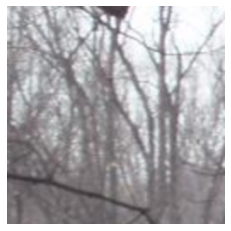

Number of People in a Image: tensor(0)


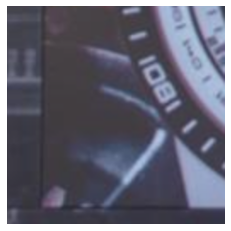

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(1)


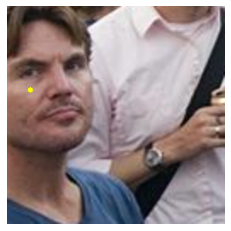

Number of People in a Image: tensor(0)


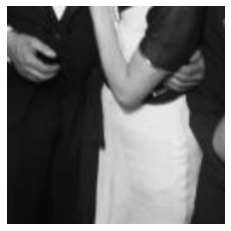

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(13)


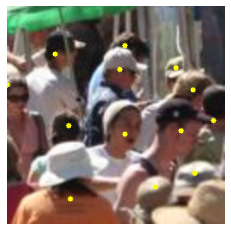

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(1)


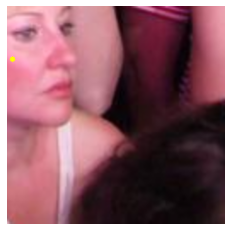

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(60)


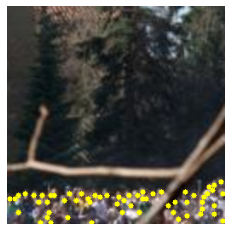

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(8)


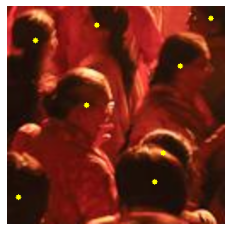

Number of People in a Image: tensor(0)


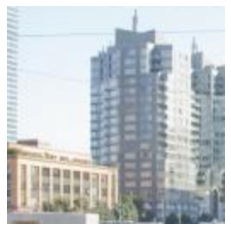

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(13)


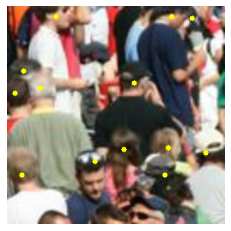

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(2)


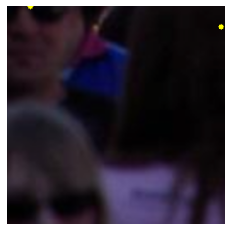

In [49]:
n_img = 10
circle_option = {'radius':3, 'color':(255, 255, 0), 'thickness':-1}
for idx, data in enumerate(train_dataset):
  if idx > n_img:
    break
  img, label, mask_label = data
  print("Number of People in a Image:", mask_label.sum())
  unnorm_img = unnormalizer(img)
  new_img = show_landmark(unnorm_img.permute(1, 2, 0).numpy(), label * torch.FloatTensor([[img.shape[1], img.shape[2]]]), circle_option)
  plt.imshow(new_img)
  plt.axis(False)
  plt.show()

# Crowd Localization Transformer

In [10]:
class BackBone(nn.Module):
  def __init__(self, name):
    super().__init__()
    self.backbone = getattr(torchvision.models, name)(pretrained=True)
    del self.backbone.avgpool
    del self.backbone.fc
    self.num_channels = list(list(self.backbone.children())[-1].children())[-1].conv3.out_channels

    #In original DETR paper, only batch norm layer is frozen. !!!!!
    #Set the backbone weights to not update
    for param in self.backbone.parameters():
      param.requires_grad = False
  
  def forward(self, x):
    for layer in self.backbone.children():
      x = layer(x)
    return x

In [11]:
class TransformerCLTR(nn.Module):
  def __init__(self, d_model=512, nhead=8, num_encoder_layers=6,
               num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
               activation="relu", normalize_before=False):
    super().__init__()
    encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, 
                                                dropout, activation)
    encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
    self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

    decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
    decoder_norm = nn.LayerNorm(d_model)
    self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

    self.d_model = d_model
    self.nhead = nhead

  def forward(self, src, query_embed, pos_embed):
    bs, c, h, w = src.shape
    src = src.flatten(2).permute(2, 0, 1)
    pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
    query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)

    memory = self.encoder(src + pos_embed)
    hs = self.decoder(query_embed, memory) # In original DETR their is addition positional embedding at the attenstion (memory + pos)
    return hs

In [12]:
tr = TransformerCLTR().to('cuda')

In [9]:
src = torch.ones((16, 512, 8, 8))
pos_embed = torch.ones((16, 512, 8, 8))
query_embed = torch.ones((64, 512))
tr(src.to('cuda'), query_embed.to('cuda'), pos_embed.to('cuda')).shape

torch.Size([64, 16, 512])

In [12]:
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

In [13]:
class PositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None, device='cuda'):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * np.pi
        self.scale = scale
        self.device = device

    def forward(self, x):
        h, w = x.shape[-2:]
        not_mask = torch.ones(1, h, w).to(self.device)
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats,
                             dtype=torch.float32).to(self.device)
        dim_t = self.temperature**(2 * (torch.div(dim_t, 2, rounding_mode='floor')) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack(
            (pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()),
            dim=4).flatten(3)
        pos_y = torch.stack(
            (pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()),
            dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [14]:
class CLTR(nn.Module):
  def __init__(self, backbone, transformer, position_embedding, num_queries):
    super().__init__()
    self.num_queries = num_queries
    self.backbone = backbone
    self.transformer = transformer
    self.position_embedding = position_embedding
    hidden_dim = transformer.d_model
    self.point_head = MLP(hidden_dim, hidden_dim, 2, 3)
    self.class_head = nn.Linear(hidden_dim, 1) ## Return a logit number
    self.query_embed = nn.Embedding(num_queries, hidden_dim)
    self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
  
  def forward(self, x):
    feat = self.input_proj(self.backbone(x))
    pos = self.position_embedding(feat)

    hs = self.transformer(feat, self.query_embed.weight, pos).transpose(0, 1)
    return {'pred_logits': self.class_head(hs),
            'pred_points': self.point_head(hs).sigmoid()}

In [15]:
d_model = 128
num_pos_feats = d_model // 2
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
num_queries = 500
backbone = 'resnet50'

backbone_model = BackBone(backbone).to('cuda')
transformer = TransformerCLTR(d_model, nhead, num_encoder_layers, num_decoder_layers).to('cuda')
position_embedding = PositionEmbeddingSine(num_pos_feats).to('cuda')
cltr = CLTR(backbone_model, transformer, position_embedding, num_queries).to('cuda')

In [15]:
test = torch.ones(16, 3, 256, 256).to('cuda')
pred = cltr(test)

In [18]:
pred['pred_points'].shape

torch.Size([16, 500, 2])

# KNN

In [16]:
class KNN(nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
  
  @torch.no_grad()
  def forward(self, x):
    if x.shape[0] <= 1:
      return torch.nan, torch.zeros(x.shape[0], 1, x.shape[1]), torch.nan
    k = min(self.k, x.shape[0]-1)
    diff_point = x.unsqueeze(0) - x.unsqueeze(1)
    diff = (diff_point ** 2).sum(-1)

    mask = diff.argsort(-1)
    mask = mask[:, 1:k+1]
    diff_consider = diff_point[torch.arange(mask.shape[0]).unsqueeze(1).repeat(1, mask.shape[1]), mask, :]
    return mask , diff_consider, diff_point

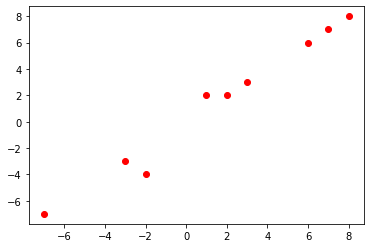

In [35]:
x = [1, 3, 2, 8, 6, 7, -3, -2, -7]
y = [2, 3, 2, 8, 6, 7, -3, -4, -7]

plt.scatter(x, y, c='r')
plt.show()

data = torch.cat([torch.FloatTensor(x).unsqueeze(1), torch.FloatTensor(y).unsqueeze(1)], dim=1)

0


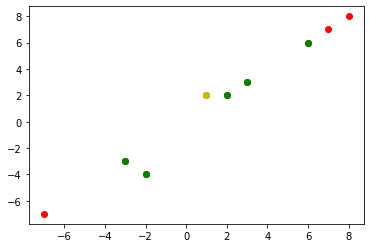

1


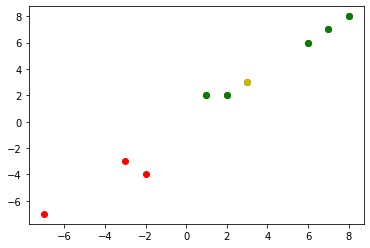

2


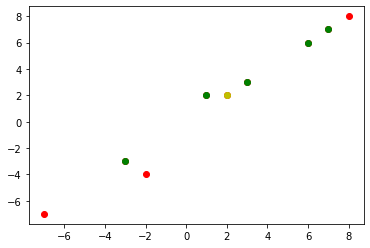

3


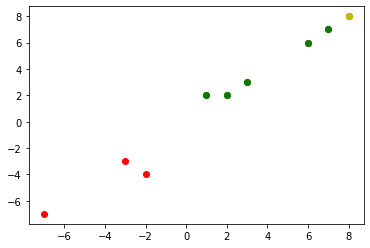

4


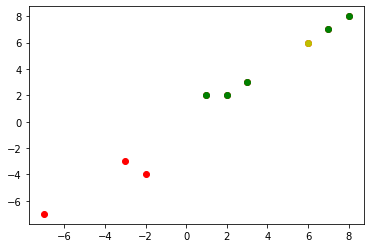

5


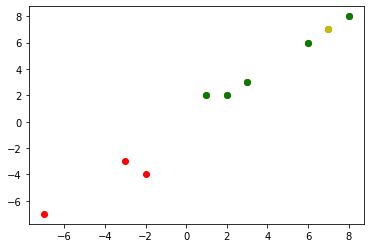

6


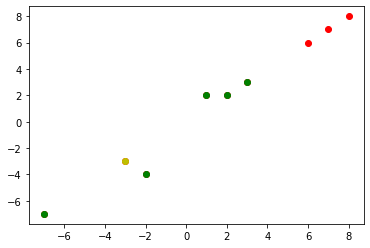

7


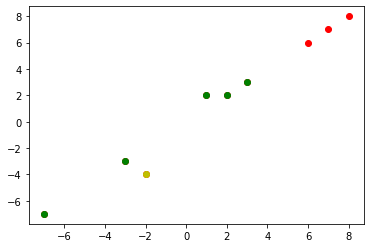

8


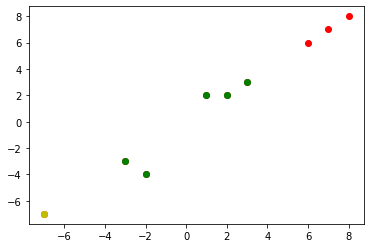

In [36]:
knn = KNN(k=5)
for idx, neighbor in enumerate(knn(data)[0]):
  print(idx)
  plt.scatter(data[:, 0], data[:, 1], c='r')
  plt.scatter(data[idx, 0], data[idx, 1], c='y')
  plt.scatter(data[neighbor, 0], data[neighbor, 1], c='g')
  plt.show()

In [84]:
mask, diff_consider, diff_point = knn(data)

In [85]:
mask.shape

(9, 5)

In [88]:
diff_consider.shape

(9, 5, 2)

In [102]:
diff_consider.mean(1)

array([[ 0.2, -1.2],
       [ 1.8,  2. ],
       [ 0.8,  1. ],
       [-4.2, -4. ],
       [-1.8, -1.6],
       [-3. , -2.8],
       [ 2.4,  2.2],
       [ 1.2,  3.4],
       [ 7.2,  7. ]])

# Matcher

In [17]:
class KMOHungarian(nn.Module):
  def __init__(self, knn, kmo=True):
    super().__init__()
    self.knn = knn
    self.kmo = kmo

  @torch.no_grad()
  def forward(self, pred, target_points, mask_target):
    bs = len(target_points)
    target_points = target_points.cpu().detach()
    mask_target = mask_target.cpu().detach()
    pred_class = pred['pred_logits'].sigmoid().cpu().detach()
    pred_points = pred['pred_points'].cpu().detach()

    knn_pred = [self.knn(data)[1].mean(1) for data in pred_points]  
    knn_target = [self.knn(data[mask_target[idx]])[1].mean(1) for idx, data in enumerate(target_points)]

    cost_point = [torch.cdist(pred_points[idx].unsqueeze(0), target_points[idx][mask_target[idx]].unsqueeze(0), p=1).squeeze(0) for idx in range(bs)]
    cost_knn = [torch.cdist(knn_pred[idx].unsqueeze(0), knn_target[idx].unsqueeze(0), p=1).squeeze(0) for idx in range(bs)]
    cost_class = [pred_class[idx].repeat((1, mask.sum())) for idx, mask in enumerate(mask_target)]
    
    indices = [linear_sum_assignment(cost_point[idx] + cost_knn[idx] - cost_class[idx] if self.kmo else cost_point[idx] - cost_class[idx]) for idx in range(bs)]
    return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [26]:
label = torch.FloatTensor([[[0, 8], [0.5, 6], [1, 7], [-1, -1]]])
mask_label = torch.tensor([[True, True, True, False]])

pred = {
  "pred_logits": torch.FloatTensor([[100], [100], [100], [100]]),
  "pred_points": torch.FloatTensor([[[0, 0], [0.5, -2], [1, -1], [-2, 7]]])
}

knn = KNN(k=2)
matcher = KMOHungarian(knn, kmo=True)
indices_kmo = matcher(pred, label, mask_label)[0]

knn = KNN(k=2)
matcher = KMOHungarian(knn, kmo=False)
indices_normal = matcher(pred, label, mask_label)[0]

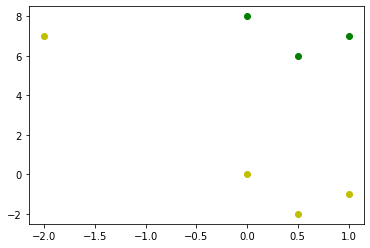

In [27]:
plt.scatter(pred["pred_points"][0, :, 0], pred["pred_points"][0, :, 1], c='y')
plt.scatter(label[0, mask_label[0], 0], label[0, mask_label[0], 1], c='g')
plt.show()

KMO Hungarian


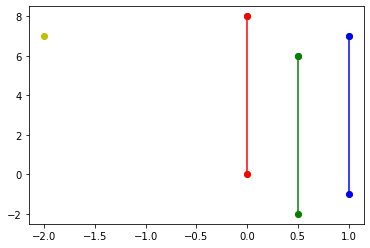

In [28]:
print("KMO Hungarian")
plt.scatter(pred["pred_points"][0, :, 0], pred["pred_points"][0, :, 1], c='y')
plt.scatter(label[0, mask_label[0], 0], label[0, mask_label[0], 1], c='g')

c = ['r', 'g', 'b']
for i in range(3):
  pred_x, pred_y = pred["pred_points"][0, indices_kmo[0][i], 0], pred["pred_points"][0, indices_kmo[0][i], 1]
  gt_x, gt_y = label[0, indices_kmo[1][i], 0], label[0, indices_kmo[1][i], 1]
  plt.scatter(pred["pred_points"][0, indices_kmo[0][i], 0], pred["pred_points"][0, indices_kmo[0][i], 1], c=c[i])
  plt.scatter(label[0, indices_kmo[1][i], 0], label[0, indices_kmo[1][i], 1], c=c[i])
  plt.plot([pred_x, gt_x], [pred_y, gt_y], c=c[i])

Normal Hungarian


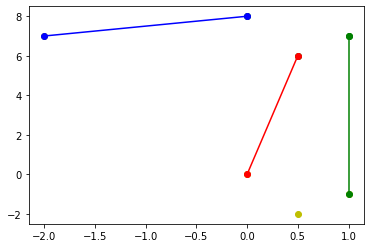

In [29]:
print("Normal Hungarian")
plt.scatter(pred["pred_points"][0, :, 0], pred["pred_points"][0, :, 1], c='y')
plt.scatter(label[0, mask_label[0], 0], label[0, mask_label[0], 1], c='g')

c = ['r', 'g', 'b']
for i in range(3):
  pred_x, pred_y = pred["pred_points"][0, indices_normal[0][i], 0], pred["pred_points"][0, indices_normal[0][i], 1]
  gt_x, gt_y = label[0, indices_normal[1][i], 0], label[0, indices_normal[1][i], 1]
  plt.scatter(pred["pred_points"][0, indices_normal[0][i], 0], pred["pred_points"][0, indices_normal[0][i], 1], c=c[i])
  plt.scatter(label[0, indices_normal[1][i], 0], label[0, indices_normal[1][i], 1], c=c[i])
  plt.plot([pred_x, gt_x], [pred_y, gt_y], c=c[i])

In [35]:
indices_kmo

(tensor([0, 1, 2]), tensor([0, 1, 2]))

# CLTR Loss

In [14]:
class FocalLoss(nn.Module):
  def __init__(self, gamma, reduction='mean'):
    super().__init__()
    self.gamma = gamma
    self.reduction = reduction
    self.bcelogit = nn.BCEWithLogitsLoss(reduction='none')

  def forward(self, input, target):
    '''
      input   : tensor's shape (bs*num_queries) 
      target  : tensor's shape (bs*num_queries)
    '''
    ce_loss = self.bcelogit(input, target)
    pt = torch.exp(-ce_loss)
    focal_loss = ((1-pt)**self.gamma * ce_loss)
    if self.reduction == 'mean':
      focal_loss = focal_loss.mean()
    return focal_loss

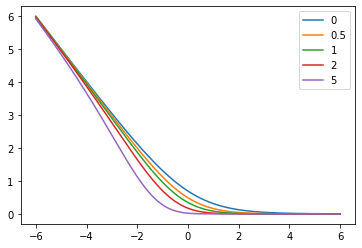

In [87]:
for gamma in [0, 0.5, 1, 2, 5]:
  focal_loss = FocalLoss(gamma, reduction='none')

  bs = 500
  target = torch.ones(bs)
  input = torch.linspace(-6, 6, bs)

  loss = focal_loss(input, target)
  plt.plot(input, loss, label=str(gamma))

plt.legend()
plt.show()

In [19]:
class LocalLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input_point, target_point, indices):
    '''
      input_point : tensor's shape (bs, num_queries, 2)
      target_point: tensor's shape (bs, num_queries, 2)
      indices     : list's length is bs [(input_indices, target_indices), (), ... ()]
    '''
    bs = input_point.shape[0]
    input_match = [input_point[idx, indices[idx][0], :] for idx in range(bs)]
    target_match = [target_point[idx, indices[idx][1], :] for idx in range(bs)]
    
    input_match = torch.cat(input_match, dim=0)
    target_match = torch.cat(target_match, dim=0)

    loss = torch.abs(input_match - target_match)
    loss = loss.sum() / bs
    return loss

In [76]:
a = torch.ones(0, 2)
b = torch.ones(1, 2)
c = torch.ones(2, 2)
torch.cat([a, b, c], dim=0).shape

torch.Size([3, 2])

In [82]:
b[[]] = 1

In [83]:
b

tensor([[1., 1.]])

In [20]:
class CLTRLoss(nn.Module):
  def __init__(self, loc_weight=2.5, gamma=2):
    super().__init__()
    self.loc_weight = loc_weight
    self.gamma = gamma
    self.local_loss = LocalLoss()
    self.focal_loss = FocalLoss(gamma)
  
  def forward(self, input, target, indices):
    '''
      input   : dictionary of pred_logits, and pred_points
        {
          pred_logits: tensor's shape (bs, num_queries) 
          pred_points: tensor's shape (bs, num_queries, 2)
        }
      target  : tensor's shape (bs, num_queries, 2)
      indices : list's length is bs [(input_indices, target_indices), (), ... ()]
    '''
    input_logits = input['pred_logits']
    input_points = input['pred_points']

    bs, num_queries = input_points.shape[:2]
    target_class = torch.zeros(bs, num_queries).to('cuda')
    for idx in range(bs):
      target_class[idx, indices[idx][0]] = 1
    
    cls_loss = self.focal_loss(input_logits.flatten(), target_class.flatten())
    loc_loss = self.local_loss(input_points, target, indices)

    return cls_loss + self.loc_weight * loc_loss

# Train

In [24]:
knn = KNN(k=4)
matcher = KMOHungarian(knn, kmo=True)

optimizer = optim.Adam(cltr.parameters(), lr=1e-4)
criteria = CLTRLoss(loc_weight=2.5, gamma=2)

num_epochs = 100
total_loss = 0
train_losses = [] 

In [25]:
for epoch in range(num_epochs):
  total_train_loss = 0 
  for data in train_dataloader:
    img, label, mask_label = data
    img, label, mask_label = img.to('cuda'), label.to('cuda'), mask_label.to('cuda')
    pred = cltr(img)

    indices = matcher(pred, label, mask_label)
    loss = criteria(pred, label, indices)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_train_loss += loss.cpu().detach().numpy()

  current_train_loss = total_train_loss / len(train_dataloader) 
  train_losses.append(current_train_loss)
  print("Epoch:", epoch)
  print("Train Loss:", current_train_loss)

Epoch: 0
Train Loss: 24.646876234757272
Epoch: 1
Train Loss: 14.606999397277832
Epoch: 2
Train Loss: 9.424003174430446
Epoch: 3
Train Loss: 6.140636833090531
Epoch: 4
Train Loss: 6.658966440903513
Epoch: 5
Train Loss: 4.728667560376619
Epoch: 6
Train Loss: 4.832584036023993
Epoch: 7
Train Loss: 4.8021852091739055
Epoch: 8
Train Loss: 4.151514467440154
Epoch: 9
Train Loss: 3.828751482461628
Epoch: 10
Train Loss: 3.5495219983552633
Epoch: 11
Train Loss: 3.165563859437641
Epoch: 12
Train Loss: 3.849252324355276
Epoch: 13
Train Loss: 4.2148104968823885
Epoch: 14
Train Loss: 3.3091074353770207
Epoch: 15
Train Loss: 3.8721154614498743
Epoch: 16
Train Loss: 4.137305931041115
Epoch: 17
Train Loss: 4.295355332525153
Epoch: 18
Train Loss: 5.1313515336889965
Epoch: 19
Train Loss: 5.641567104741147
Epoch: 20
Train Loss: 4.971339526929353
Epoch: 21
Train Loss: 4.395798620424773
Epoch: 22
Train Loss: 4.766042746995625
Epoch: 23
Train Loss: 4.124266160161872
Epoch: 24
Train Loss: 4.165848782188014
Ep

In [26]:
len(train_dataloader)

19

In [49]:
pred["pred_logits"][0].shape

torch.Size([500, 1])

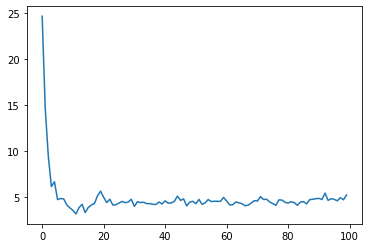

In [27]:
plt.plot(np.arange(num_epochs), train_losses)